# Imports

In [112]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import ast
from textblob import TextBlob
import re
import string
from collections import Counter
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

Data sets

In [113]:
df_ted_main = pd.read_csv("data/ted_main.csv")
df_ted_transcripts = df = pd.read_csv("data/transcripts.csv")

Drop columns we don't use from ted_main

In [114]:
df_ted_main.drop(['description', 'film_date', 'main_speaker', 'name', 'event', 'num_speaker', 'related_talks', 'speaker_occupation', 'title', 'url'], axis=1, inplace=True)

# Preprocessing and analysis
## One hot encoding

One hot encoding tags
- iterate through the dataset to change string formed list into normal list and
- replacing string version of a list for the list type

In [115]:
for i, row in df_ted_main.iterrows():
    element_list_form = ast.literal_eval(df_ted_main.at[i,'tags'])
    element_list_form = [i.strip() for i in element_list_form]
    
    df_ted_main.at[i,'tags'] = element_list_form

One hot encoding with column named "tags"
- since "tags" is a series on each row, we need to split them first and then we can do one hot encoding

In [116]:
df_ted_main = df_ted_main.drop('tags', 1).join(
    pd.get_dummies(
        pd.DataFrame(df_ted_main.tags.tolist()).stack()
    ).astype(int).sum(level=0)
)

## Rating analysis

In [117]:
df_ted_main['ratings']=df_ted_main['ratings'].str.replace("'",'"')

df_ted_main=df_ted_main.merge(df_ted_main.ratings.apply(lambda x: pd.Series(pd.read_json(x)['count'].values,index=pd.read_json(x)['name'])), 
            left_index=True, right_index=True)

df_ted_main.drop('ratings', axis=1, inplace=True)

## Sentiment analysis of transcript

In [118]:
pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

df_ted_transcripts['polarity'] = df_ted_transcripts['transcript'].apply(pol)
df_ted_transcripts['subjectivity'] = df_ted_transcripts['transcript'].apply(sub)

Merging both data sets and deleting the rows which don't have a transcript

In [119]:
df_ted_talks = pd.merge(df_ted_main, df_ted_transcripts, left_index=True, right_index=True)

Deleting rows

In [120]:
del df_ted_talks['transcript']
del df_ted_talks['url']

## NLP

In [121]:
result = pd.merge(df_ted_main, df_ted_transcripts, left_index=True, right_index=True)
result = result.sort_values('views', ascending = False)
result_top = result.head(15)

In [122]:
def clean_text_round1(text):
#     Make all text lower case.
    text = text.lower()
#   Looks at the things in the square bracts and replaces them with nothing.  
    text = re.sub('\[.*?\]', ' ', text)
#   Replaces punctuation marks with nutting.
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
#   Replaces numbers with nothing  
    text = re.sub('\w*\d\w*', ' ', text)
    return text

round1 = lambda x: clean_text_round1(x)

data_clean = pd.DataFrame(result_top.transcript.apply(round1))

In [123]:
def clean_text_round2(text):
    text = re.sub('[""''*,:;<>_-]', ' ', text)
    text = re.sub('\n', ' ', text)
    return text

round2 = lambda x: clean_text_round2(x)

data_clean = pd.DataFrame(data_clean.transcript.apply(round2))

In [124]:
cv = CountVectorizer(stop_words='english')
data_cv = cv.fit_transform(data_clean.transcript)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = data_clean.index

In [125]:
data = data_dtm.transpose()

In [126]:
top_dict = {}

for c in data.columns:
    top = data[c].sort_values('index',ascending = False).head(30)
    top_dict[c]= list(zip(top.index, top.values))

In [127]:
words = []
for speech in data.columns:
    top = [word for (word, count) in top_dict[speech]]
    for t in top:
        words.append(t)
        
len(words)

450

In [128]:
Counter(words).most_common()

[('people', 10),
 ('like', 9),
 ('just', 9),
 ('world', 9),
 ('years', 9),
 ('things', 8),
 ('way', 7),
 ('ve', 7),
 ('laughter', 6),
 ('said', 6),
 ('think', 5),
 ('know', 5),
 ('new', 5),
 ('time', 5),
 ('want', 4),
 ('really', 4),
 ('didn', 4),
 ('make', 4),
 ('look', 4),
 ('change', 4),
 ('different', 4),
 ('did', 3),
 ('going', 3),
 ('life', 3),
 ('education', 2),
 ('don', 2),
 ('say', 2),
 ('school', 2),
 ('come', 2),
 ('kids', 2),
 ('wrong', 2),
 ('human', 2),
 ('thing', 2),
 ('day', 2),
 ('young', 2),
 ('write', 2),
 ('kind', 2),
 ('room', 2),
 ('need', 2),
 ('women', 2),
 ('making', 2),
 ('students', 2),
 ('applause', 2),
 ('good', 2),
 ('talking', 2),
 ('art', 2),
 ('started', 2),
 ('lot', 2),
 ('wanted', 2),
 ('rule', 2),
 ('got', 2),
 ('love', 2),
 ('somebody', 2),
 ('money', 2),
 ('climate', 2),
 ('today', 2),
 ('teachers', 2),
 ('right', 2),
 ('year', 2),
 ('information', 2),
 ('children', 1),
 ('gillian', 1),
 ('went', 1),
 ('earth', 1),
 ('dance', 1),
 ('isn', 1),
 ('le

In [129]:
add_stop_words = [word for word, count in Counter(words).most_common() if count > 6]

In [130]:
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

cv = CountVectorizer(stop_words=stop_words)
data_cv = cv.fit_transform(data_clean.transcript)
data_stop = pd.DataFrame(data_cv.toarray(), columns =cv.get_feature_names())
data_stop.index = data_clean.index

In [131]:
# Let's make some word clouds!
# Terminal / Anaconda Prompt: conda install -c conda-forge wordcloud

wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2", 
               max_font_size=150, random_state=42)

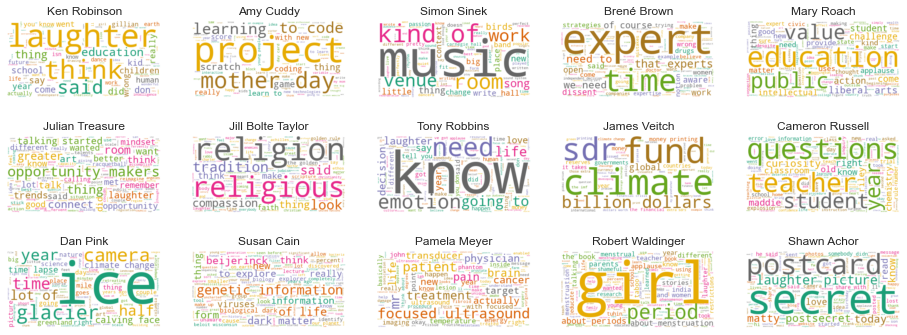

In [132]:
# Reset the output dimensions
plt.rcParams['figure.figsize'] = [16, 6]

full_names =['Ken Robinson','Amy Cuddy','Simon Sinek', 'Brené Brown', 'Mary Roach','Julian Treasure','Jill Bolte Taylor',
             'Tony Robbins','James Veitch','Cameron Russell','Dan Pink','Susan Cain','Pamela Meyer','Robert Waldinger','Shawn Achor']

# Create subplots for each speaker
for index, speech in enumerate(data.columns):
    wc.generate(data_clean.transcript[speech])
    
    plt.subplot(3, 5, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(full_names[index])
    
plt.show()

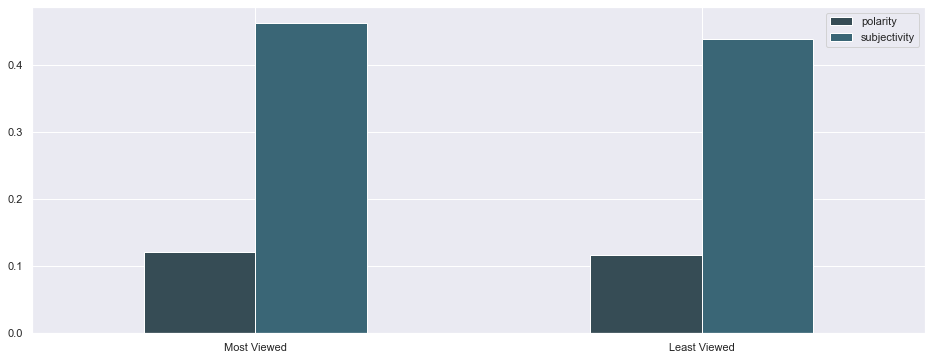

In [133]:
sns.set()
mean_pol = [0.121888, 0.116913]
mean_sub = [0.463702, 0.439423]
index = ['Most Viewed', 'Least Viewed']
with sns.color_palette("GnBu_d", 8):
    df_mean = pd.DataFrame({'polarity': mean_pol,
                   'subjectivity': mean_sub}, index=index)
    ax = df_mean.plot.bar(rot=0)

## Split data set

A feature we want to predict: views, and removing feature we want to predict from the original data set

In [134]:
labels = np.array(df_ted_talks['views'])

df_ted_talks = df_ted_talks.drop('views', axis = 1)

Splitting

In [135]:
# Splitting
train_set, test_set, train_labels, test_labels = train_test_split(df_ted_talks, labels, test_size = 0.14, random_state = 42)

## Standardization

Fit on training set only

In [136]:
scaler = StandardScaler()
scaler.fit(train_set)

StandardScaler()

Apply transform to both the training set and the test set

In [137]:
df_train_set_scaled = scaler.transform(train_set)
df_test_set_scaled = scaler.transform(test_set)

Convert to data frames

In [138]:
df_train_set = pd.DataFrame(df_train_set_scaled, index=train_set.index, columns=train_set.columns)
df_test_set = pd.DataFrame(df_test_set_scaled, index=test_set.index, columns=test_set.columns)

## Principal Component Analysis
### Getting tag columns
Columns without PCA

In [139]:
columns_without_pca = ['views','subjectivity','polarity','Inspiring','Obnoxious','OK',
                                  'Jaw-dropping','Persuasive','Unconvincing','Fascinating','Informative','Confusing',
                                  'Longwinded','Courageous','Ingenious','Beautiful','Funny','comments','duration',
                                  'languages','published_date']

Get tag columns for both training set and test set

In [140]:
tag_columns_train_set = df_train_set[df_train_set.columns.difference(columns_without_pca)]
tag_columns_test_set = df_test_set[df_test_set.columns.difference(columns_without_pca)]

Saving indexes of training set and test set for the next step.
PCA will convert dataframe into numpy array and indexes will be lost.
This way we will keep them stored.
1. Save tag columns as tag_columns_train_set_indexes and tag_columns_test_set_indexes
2. Save all tag columns as lists
3. Remove tag columns from original sets

In [141]:
tag_columns_train_set_indexes = tag_columns_train_set.index
tag_columns_test_set_indexes = tag_columns_test_set.index

tag_columns_train_set_list = list(tag_columns_train_set)
tag_columns_test_set_list = list(tag_columns_test_set)

df_train_set.drop(tag_columns_train_set_list, axis=1, inplace=True)
df_test_set.drop(tag_columns_test_set_list, axis=1, inplace=True)

### Launch PCA

In [142]:
pca = PCA(.80)

Fit PCA only on training set of tag columns and use PCA to transform both sets of tag columns

In [143]:
pca.fit(tag_columns_train_set)

tag_columns_train_set = pca.transform(tag_columns_train_set)
tag_columns_test_set = pca.transform(tag_columns_test_set)

Combine PCA transformed training set and test set of tag columns with original training set and test set

In [144]:
feat_cols_train = ['feature'+str(i) for i in range(tag_columns_train_set.shape[1])]
df_pca_train = pd.DataFrame(tag_columns_train_set, columns=feat_cols_train, index=tag_columns_train_set_indexes)

feat_cols_test = ['feature'+str(i) for i in range(tag_columns_test_set.shape[1])]
df_pca_test = pd.DataFrame(tag_columns_test_set, columns=feat_cols_test, index=tag_columns_test_set_indexes)


Result of combining

In [145]:
df_train_set = df_train_set.join(df_pca_train, how="left")
df_test_set = df_test_set.join(df_pca_test, how="left")

# Predicting

In [ ]:
rf = RandomForestRegressor(criterion='mae',max_depth=25, max_features=70, n_estimators=70, random_state=42)
gbr = GradientBoostingRegressor(random_state=42)
lr = LinearRegression()  

model_dic = {"Random Forest": rf, "Gradient Booster": gbr, 'Linear Regression': lr}
names = []
scores = []

for name, model in model_dic.items():
    # Train the model on training data
    model.fit(df_train_set, train_labels)
    # Predict on test set
    model.predict(df_test_set)
    # get the score
    score = model.score(df_test_set, test_labels)
    # save the name and the score
    names.append(name)
    scores.append(score)

Visualize

In [ ]:
vis_data = {'Model':names, 'Score':scores} 
vis_df = pd.DataFrame(vis_data) 
vis_df

In [ ]:
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [ ]:
sns.set(style="whitegrid")

ax = sns.barplot("Model", y="Score", data=vis_df,
                 palette="GnBu_d")

show_values_on_bars(ax)

In [ ]:
importances = pd.DataFrame({'Feature': df_train_set.columns, 
                                'Importance': gbr.feature_importances_})

importances_ratings = importances[4:18]
importances_ratings_sorted = importances_ratings.sort_values(by=['Importance'], axis='index', ascending=False)
importances_ratings_sorted